COMS 4731 Computer Vision -- Homework 3
==========

- In this homework, you will construct a panorama by stitching several individual and overlapping images together.
    - **Problem 1: Homography (20 points)**
        - Implement the `compute_homography` function.
        - Implement the `apply_homography` function.
    - **Problem 2: Warping (20 points)**
        - Implement the `backward_warp_img` function.
    - **Problem 3: SIFT and RANSAC (20 points)**
        - Implement the `RANSAC` function.
    - **Problem 4: Image Blending (20 points)**
        - Implement the `blend_image_pair` function.
    - **Problem 5: Creating Panoramas (20 points)**
        - Implement the `stitch_img` function.
        - Create a panorama using your own photos. 

- Your job is to implement the sections marked with TODO to complete the tasks.

- Submission 
    - Please submit the notebook (ipynb and pdf) including the output of all cells.

- Note: Please install OpenCV (version 3.4.2.16) by running the following command in the terminal
    - `pip install opencv-python==3.4.2.16; pip install opencv-contrib-python==3.4.2.16`
    - Otherwise, you may encounter error when running SIFT.

Setup
-----

Before we get started, let's visualize the three separate images we ultimately want to stitch together. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
import sys
import random
import cv2
import math
%matplotlib inline

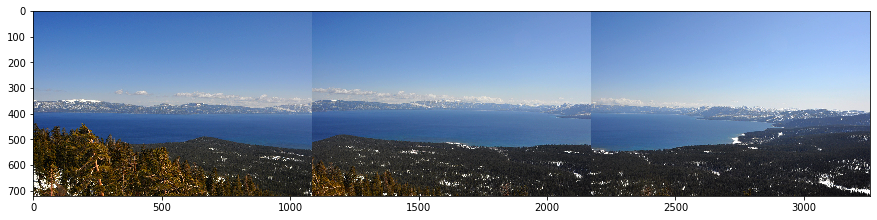

In [3]:
plt.rcParams['figure.figsize'] = [15, 15]

def load_image(filename):
    img = np.asarray(Image.open(filename))
    img = img.astype("float32")/255.
    return img

def show_image(img):
    plt.imshow(img, interpolation='nearest')
    
center_img = load_image("mountain_center.png")
left_img   = load_image("mountain_left.png")
right_img  = load_image("mountain_right.png")

show_image(np.concatenate([left_img, center_img, right_img], axis=1))

Problem 1: Homography
=========

You should finish implementing two functions below:

1. **compute_homography(src, dst)** receives two matrices of points, which are each Nx2. The function should return the homography matrix H that maps points from the source to the target. This return value should be a 3x3 matrix. We have given you most of the solution already. You just need to implement the A matrix.

2. **apply_homography(src, H)** receives points src (Nx2 matrix) and the homography transformation H (3x3 matrix). This function should use the homography matrix to transform src into the destination. Remember that you need to implement this using homogenous coordinates.

In [4]:
def compute_homography(src, dst):
    '''Computes the homography from src to dst.
    
    Input:
        src: source points, shape (n, 2)
        dst: destination points, shape (n, 2)
    Output:
        H: homography from source points to destination points, shape (3, 3)
        
    TODO: Implement the A matrix. 
    '''
    src = np.asarray(src)
    dst = np.asarray(dst)
    A = np.zeros([2*src.shape[0], 9])
    i = 0
    for s,d in zip(src,dst):
        a1 = [s[0],s[1],1,0,0,0,-d[0]*s[0],-d[0]*s[1],-d[0]]
        a2 = [0,0,0,s[0],s[1],1,-d[1]*s[0],-d[1]*s[1],-d[1]]
        A[i] = a1
        i += 1
        A[i] = a2
        i += 1
        
    A = np.asarray(A)
    #print(A.shape)
    
    
    #print("Src Matrix:\n",src,"\n","Dst Matrix:\n",dst)
    #print("A Matrix:\n",A)
    w, v = np.linalg.eig(np.dot(A.T, A))
    index = np.argmin(w)
    H = v[:, index].reshape([3,3])
    #print(H)
    '''
    A = cv2.findHomography(src,dst,cv2.RANSAC,5.0)
    A = np.asarray(A)
    H = A[0]
    print(H)
    '''
    return H

def apply_homography(src, H):
    '''Applies a homography H onto the source points.
    
    Input:
        src: source points, shape (n, 2)
        H: homography from source points to destination points, shape (3, 3)
    Output:
        dst: destination points, shape (n, 2)
    
    TODO: Implement the apply_homography function
    '''
    dst = []
    src = np.asarray(src)
    for each in src:
        each = [each[0],each[1],1]
        #each = np.expand_dims(each, 0 )
        #print(each)
        #each = np.transpose(each)
        
        
        #print("Origin x,y Coordinates with z = 1: \n",each)
        each = np.dot(H,each)
        
        #print("Multiple by Homographty Matrix: \n",each)
        each = [each[0]/each[2],each[1]/each[2]]
        #print("Normalized By z axis x = x/z, y = y/z: \n",each)
        dst.append(each)
    
    dst = np.asarray(dst)
    #print("Transformed destination Matrix: \n", dst)
    return dst 

To help you debug the homography code, we have provided a test below. This uses pairs of points (src_pts and dst_pts) to compute the homography. Then, it applies the homography on held-out points (test_pts), and visualizes the correspondence as red lines between the two images. If you have correctly implemented compute_homography() and apply_homography, the red lines should connect the same points in both images.

Your solution differs from our solution by: 0.000000
If your solution is correct, the red lines will match to the same points in both images below:


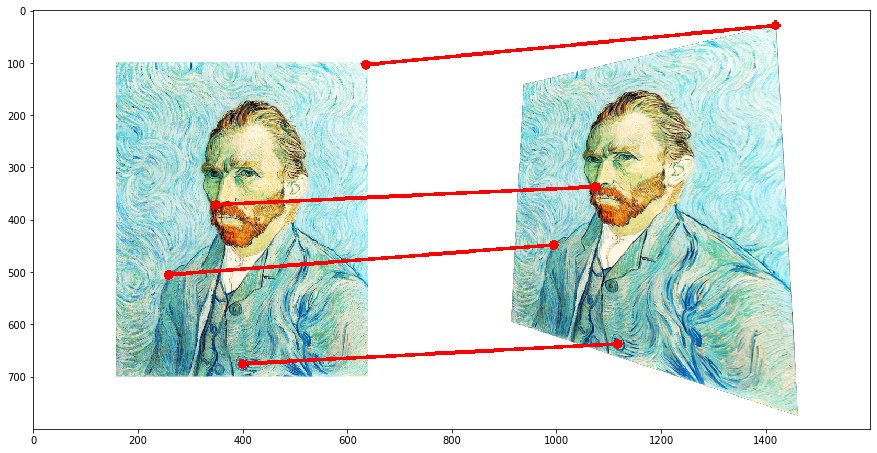

In [5]:
def test_homography():
    src_img = load_image('portrait.png')[:, :, :3]
    dst_img = load_image('portrait_transformed.png')
    whole_img = np.concatenate((src_img, dst_img), axis=1)

    src_pts = np.matrix('347, 313; 502, 341; 386, 571; 621, 508')
    dst_pts = np.matrix('274, 286; 436, 305; 305, 527; 615, 506')
    H = compute_homography(src_pts, dst_pts)

    test_pts = np.matrix('259, 505; 350, 371; 400, 675; 636, 104')
    match_pts = apply_homography(test_pts, H)
    
    match_pts_correct = np.matrix('195.13761083, 448.12645033;'
                                  '275.27269386, 336.54819916;'
                                  '317.37663747, 636.78403426;'
                                  '618.50438823, 28.78963905')

    print('Your solution differs from our solution by: %f'
          % np.square(match_pts - match_pts_correct).sum())

    for i in range(test_pts.shape[0]):
        test_x = test_pts[i, 0]
        test_y = test_pts[i, 1]
        match_x = int(round(match_pts[i, 0] + 800))
        match_y = int(round(match_pts[i, 1]))

        cv2.line(whole_img,
            (test_x, test_y), 
            (match_x, match_y), 
            (255, 0, 0), thickness=5)
        cv2.circle(whole_img,
            (test_x, test_y),
            4, (255, 0, 0), thickness=10)
        cv2.circle(whole_img,
            (match_x, match_y),
            4, (255, 0, 0), thickness=10)

    print('If your solution is correct, the red lines will match to the same points in both images below:')
    show_image(np.clip(whole_img, 0, 1)) 

test_homography()

Problem 2: Warping
=====

When we map a source image to its destination image using a homography, we may encounter a problem where multiple pixels of the source image are mapped to the same point of its destination image. What's more, some pixels of the destination image may not be mapped to any pixels of source image. What should we do?

Suppose we had homography $H$, source pixel $s$ with coordinates $(x_s, y_s)$, and destination pixel $d$ with coordinates $(x_d, y_d)$. Then, $H \cdot \tilde{s} = \tilde{d}$ (where, $s$, $d$ are in homogenous space).

To deal with this problem, we warp in the opposite direction: we map the pixels of the destination image back to source image, and then use the color in the source image as its color. More precisely, for each destination pixel $d = (x_d, y_d)$, we take $H^{-1} \cdot \tilde{d}$ to obtain the coordinate of its associated source pixel, $\tilde{s}$ (from which $s$ can be found). If $s$ is within the bounds of the source image, we take the intensity of $s$ to be the intensity of $d$.

Repeating this process over the entire destination image ensures that there are no gaps in the final result. This process is called "backward warping".


In [9]:
def backward_warp_img(src_img, H, dst_img_size):
    '''Backward warping of the source image using a homography.
    
    Input:
        src_img: source image, shape (m, n, 3)
        H: homography from destination to source image, shape (3, 3)
        dst_img_size: height and width of destination image, shape (2,)
    Output:
        dst_img: destination image, shape (m, n, 3)
    
    TODO: Implement the backward_warp_img function. 
    '''
    height,width= dst_img_size
    dst_img = np.zeros((height,width,3))
    print(np.shape(src_img))
    for i in range(height):
        for j in range(width):
            xyz_dst = [j,i,1]
            #xyz_dst = np.transpose(xyz_dst)
            xyz_src = np.dot(H,xyz_dst)
            xyz_src = [xyz_src[0]/xyz_src[2],xyz_src[1]/xyz_src[2]]
            #print(xyz_src)
            x , y = int(round(xyz_src[0])),int(round(xyz_src[1]))
            #print(x,y)
            if (0 < x < np.shape(src_img)[1]) and (0 < y < np.shape(src_img)[0]):
                dst_img[i][j] = src_img[y][x]
    print(dst_img.shape)
    return dst_img

def binary_mask(img):
    '''Create a binary mask of the image content.
    
    Input:
        img: source image, shape (m, n, 3)
    Output:
        mask: image of shape (m, n) and type 'int'. For pixel [i, j] of mask, if img[i, j] > 0 
              in any of its channels, mask[i, j] = 1. Else, (if img[i, j] = 0), mask[i, j] = 0.
    '''

    mask = (img[:, :, 0] > 0) | (img[:, :, 1] > 0) | (img[:, :, 2] > 0)
    mask = mask.astype("int")
    
    return mask

Use the function below to help debug your implementation. If it is correct, it should warp Van Gogh's self-portrait onto the building side.

(400, 327, 3)
(460, 640, 3)


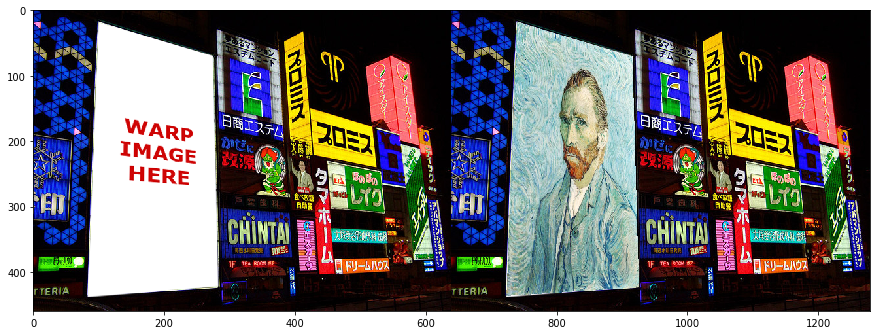

In [11]:
def test_warp():
    src_img = load_image('portrait_small.png')
    canvas = load_image('Osaka.png')
    src_pts = np.matrix('1, 1; 1, 400; 326, 1; 326, 400')
    canvas_pts = np.matrix('100, 18; 84, 437; 276, 71; 286, 424')
    H = compute_homography(src_pts, canvas_pts)
    dst_img = backward_warp_img(src_img, np.linalg.inv(H), [canvas.shape[0], canvas.shape[1]])
    dst_mask = 1 - binary_mask(dst_img)
    dst_mask = np.stack((dst_mask,) * 3, -1)
    out_img = np.multiply(canvas, dst_mask) + dst_img
    warp_img = np.concatenate((canvas, out_img), axis=1)
    
    show_image(np.clip(warp_img, 0, 1))
    
test_warp()

Problem 3: SIFT and RANSAC
====

SIFT Keypoints
--------------

So far, we have manually defined corresponding keypoints for both estimating homographies and warping. We want to automate this now. However, if we just take two photos, how do we know which points correspond? We could estimate SIFT keypoints, and take the nearest neighbor between them. The code below computes SIFT keypoints, and visualizes the matches.

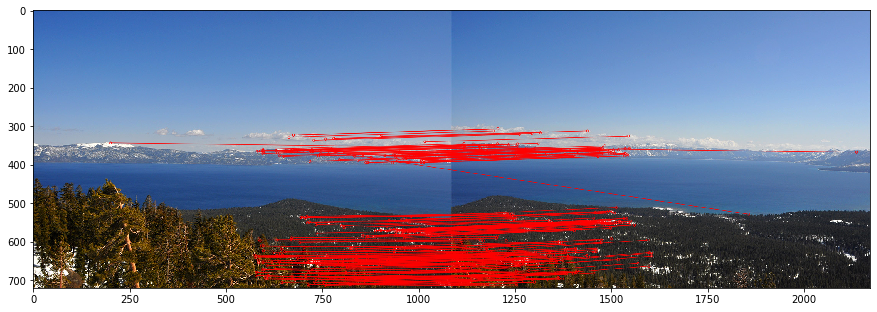

In [12]:
def genSIFTMatchPairs(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    
    pts1 = np.zeros((250,2))
    pts2 = np.zeros((250,2))
    for i in range(250):
        pts1[i,:] = kp1[matches[i].queryIdx].pt
        pts2[i,:] = kp2[matches[i].trainIdx].pt
    
    return pts1, pts2, matches[:250], kp1, kp2

def test_matches():
    img1 = cv2.imread('mountain_left.png')
    img2 = cv2.imread('mountain_center.png')
    pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(img1, img2)

    matching_result = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2, matchColor=(0,0,255))
    plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))

test_matches()

Notice that the matches are not all correct. There is a substantial amount of noise or incorrect matches. If we include these wrong matches in our homography estimation, what will happen? Think about this, and convince yourself why it will not work well.

RANSAC
------
Instead, we will use RANSAC, which is an optimization algorithm that finds correspondences while also discarding the outliers. Implement the RANSAC function below.

In [14]:
def RANSAC(Xs, Xd, max_iter, eps):
    '''Finds correspondences between two sets of points using the RANSAC algorithm.
    
    Input:
        Xs: the first set of points (source), shape [n, 2]
        Xd: the second set of points (destination) matched to the first set, shape [n, 2]
        max_iter: max iteration number of RANSAC
        eps: tolerance of RANSAC
    Output:
        inliers_id: the indices of matched pairs when using the homography given by RANSAC
        H: the homography, shape [3, 3]
    
    TODO: Implement the RANSAC function. 
    '''
    best_score =  0
    best_H = []
    best_indice = []
    Xs = np.asarray(Xs)
    Xd = np.asarray(Xd)
    for i in range(max_iter):
        sample = random.sample(range(0,Xs.shape[0]),4)
        src = np.asarray([Xs[sample[0]],Xs[sample[1]],Xs[sample[2]],Xs[sample[3]]])
        dst = np.asarray([Xd[sample[0]],Xd[sample[1]],Xd[sample[2]],Xd[sample[3]]])
        H = compute_homography(src,dst)
        if True in np.iscomplex(H):
            print("complex H")
            continue
        newDst = apply_homography(Xs,H)
        originDst = Xd
        score = 0
        indice= []
        if True in np.iscomplex(newDst):
            print("complex newDst")
            continue
        
        for i in range(newDst.shape[0]):
            #n = math.sqrt((originDst[i,0]-newDst[i,0])**2+(originDst[i,1]-newDst[i,1])**2)
            n = np.linalg.norm(originDst[i]-newDst[i])
            if np.iscomplex(n):
                continue
            if n < eps:
                score +=1
                indice.append(i)
        if best_score < score:
            best_H = H
            best_score = score
            best_indice = indice
            
    return best_indice , best_H
        
        

Now, let's visualize the matches between keypoints after using your RANSAC implementation. If you implemented RANSAC correctly, the outlier matches should be automatically discarded.

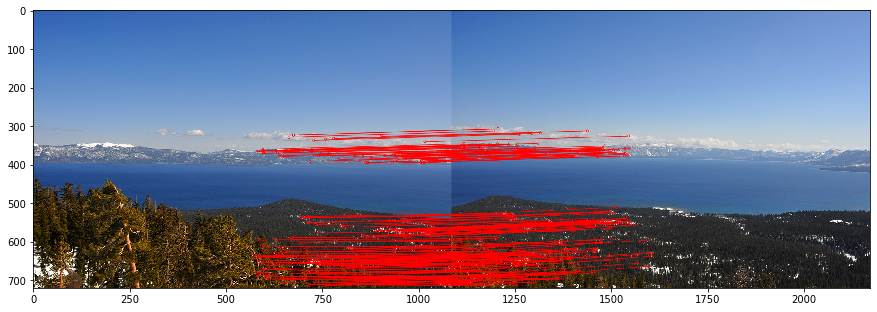

In [15]:
def test_ransac():
    img1 = cv2.imread('mountain_left.png')
    img2 = cv2.imread('mountain_center.png')

    pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(img1, img2)
    
    inliers_idx, H = RANSAC(pts1, pts2, 500, 20)
    
    new_matches = []
    for i in range(len(inliers_idx)):
        new_matches.append(matches[inliers_idx[i]])

    matching_result = cv2.drawMatches(img1, kp1, img2, kp2, new_matches, None, flags=2, matchColor=(0,0,255))
    plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))
    
test_ransac()

Problem 4: Image Blending
====

We have now implemented code to estimate correspondences between photos, estimate the homography, and warp one image into the other image. Before we can build our panorama making application, the next piece we need is code to seamlessly blend two images together.

In [25]:
from scipy.ndimage.morphology import distance_transform_edt as euc_dist

def blend_image_pair(src_img, src_mask, dst_img, dst_mask, mode):
    '''Given two images and their binary masks, blend the two images.
    
    Input:
        src_img: First image to be blended, shape (m, n, 3)
        src_mask: src_img's binary mask, shape (m, n)
        dst_img: Second image to be blended, shape (m, n, 3)
        dst_mask: dst_img's binary mask, shape (m, n)
        mode: Blending mode, either "overlay" or "blend"
    Output:
        Blended image of shape (m, n, 3)
    
    TODO: Implement the blend_image_pair function.
    '''
    '''
    src_mask = np.stack((src_mask,) * 4, -1)
    src_img = np.multiply(src_img, src_mask)
    dst_mask = np.stack((dst_mask,) * 4, -1)
    dst_img = np.multiply(dst_img, dst_mask)
    '''
    src_mask = euc_dist(src_mask)
    dst_mask = euc_dist(dst_mask)
    dst = np.copy(dst_img)
    for i in range(np.shape(src_img)[0]):
        for j in range(np.shape(src_img)[1]):
            if i < np.shape(dst_img)[0] and j < np.shape(dst_img)[1]:
                if mode == "blend":
                    if src_img[i,j].all() == 0 and dst_img[i,j].all() == 0:
                        continue
                    elif src_img[i,j].all() != 0 and dst_img[i,j].all() == 0:
                        dst[i,j] = src_img[i,j,0:3]
                    elif src_img[i,j].all() == 0 and dst_img[i,j].all() != 0:
                        continue
                    elif src_img[i,j].all() != 0 and dst_img[i,j].all() != 0:
                        dst[i,j] = src_img[i,j,0:3]*(src_mask[i,j]/(src_mask[i,j]+dst_mask[i,j])) + dst_img[i,j,0:3]*(dst_mask[i,j]/(src_mask[i,j]+dst_mask[i,j]))
                if mode == "overlay":
                    if src_img[i,j].all() != 0 and dst_img[i,j].all() != 0:
                        dst[i,j] = dst_img[i,j,0:3]

                    else:
                        dst[i,j] = dst_img[i,j,0:3] + src_img[i,j,0:3]
    #show_image(dst_img)
    #show_image(dst_mask)
    return dst 

To test your implementation, you can use the function below. It supports two modes. Setting mode="blend" should seamlessly blend the two images. Setting mode="overlay" will just combine them without any blending.

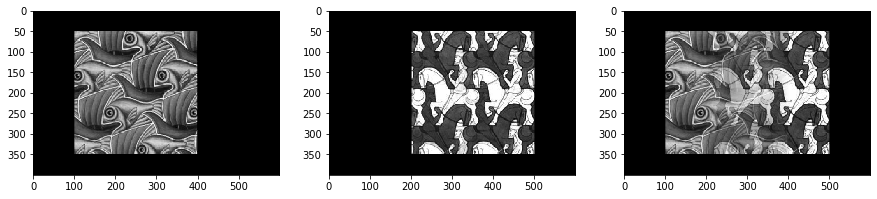

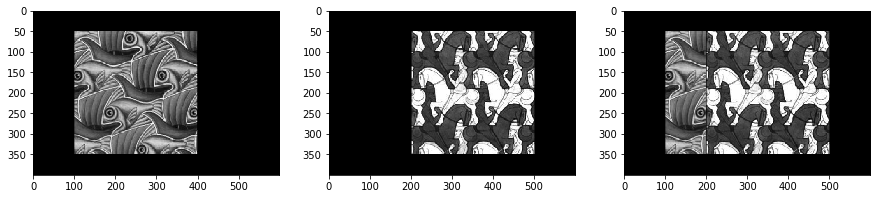

In [26]:
def test_blend(mode):
    fish_img = load_image("escher_fish.png")[:, :, :3]
    horse_img = load_image("escher_horsemen.png")[:, :, :3]

    blend_img = blend_image_pair(fish_img, binary_mask(fish_img), horse_img, binary_mask(horse_img), mode)

    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(fish_img, cmap='gray')
    axarr[1].imshow(horse_img, cmap='gray')
    axarr[2].imshow(blend_img,cmap='gray')
    
test_blend("blend")
test_blend("overlay")

Problem 5: Creating Panoramas
====

We are now ready to make a panorama from the three images at the beginning. The function below receives a Python list of images, which you should stitch together to form one large image. You will need to call most of the functions defined above in order to successfully do this. 

To receive full credit, make sure you have stitched the three images together with very little seam between them. 

In [34]:
def stitch_img(imgs):
    '''Stitch a list of images together.
    
    Input: 
        imgs: a list of images.
    Output:
        stitched_img: a single stiched image.
        
    TODO: implement the stitch_img function. 
    '''
    pad_size_lr = int(imgs[0].shape[0]*((len(imgs)-1)/2))
    pad_size_ud = 50
    blend_image = cv2.copyMakeBorder(imgs[0],pad_size_ud,pad_size_ud,pad_size_lr,pad_size_lr,cv2.BORDER_CONSTANT,value=0)
    blend_image = blend_image.astype("float32")/255.
    show_image(blend_image)
    for i in range(1,len(imgs)):
        src = imgs[i]
        dst = imgs[0]
        h = dst.shape[0]
        w = dst.shape[1]
        src = cv2.copyMakeBorder(src,pad_size_ud,pad_size_ud,pad_size_lr,pad_size_lr,cv2.BORDER_CONSTANT,value=0)
        dst = cv2.copyMakeBorder(dst,pad_size_ud,pad_size_ud,pad_size_lr,pad_size_lr,cv2.BORDER_CONSTANT,value=0)
        h = dst.shape[0]
        w = dst.shape[1]
        src1 = src.astype("float32")/255.
        dst1 = dst.astype("float32")/255.
        pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(src, dst)
        print("points found")
        inliers_idx, H = RANSAC(pts1, pts2, 1000, 5)
        print("Ransac complete")
        dst_img = backward_warp_img(src1, np.linalg.inv(H), [h, w])
        print("backward_warp complete")
        blend_image = blend_image_pair(dst_img, binary_mask(dst_img), blend_image, binary_mask(blend_image), "blend")
        print("blend_image complete")
    blend_image = np.multiply(blend_image,255).astype(int)
    print(blend_image.shape)
    blend_image = blend_image[pad_size_ud:(blend_image.shape[0]-pad_size_ud),pad_size_lr//6:(blend_image.shape[1]-pad_size_lr//6),:]
    print(blend_image.shape)
    return blend_image

Use the below code to test your implementation. This code just reads in the images, calls the stitch_img() function, and plots the results.

points found
complex H
Ransac complete
(820, 2526, 3)
(820, 2526, 3)
backward_warp complete
blend_image complete
points found
complex H
Ransac complete
(820, 2526, 3)
(820, 2526, 3)
backward_warp complete
blend_image complete
(820, 2526, 3)
(720, 2286, 3)


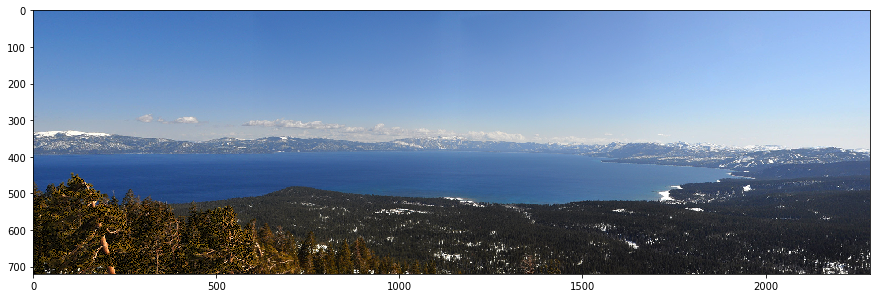

In [36]:
center_img = cv2.imread("mountain_center.png")
left_img = cv2.imread("mountain_left.png")
right_img = cv2.imread("mountain_right.png")
final_img = stitch_img([center_img, left_img, right_img])
plt.imshow(cv2.cvtColor(final_img.astype("uint8"), cv2.COLOR_BGR2RGB)); 

In [30]:
print(final_img.shape)

(720, 2322, 3)


Make Your Own Panarama
--- 

Use a digital camera, such as from your phone, and take three or more photos to create your own panaroma. Remember to be stand in place and only rotate the camera (Think about: why?). Include them in your submission, and we will show the best ones during lecture.

points found
Ransac complete
(822, 2723, 3)
(822, 2723, 3)
backward_warp complete
blend_image complete
points found
complex H
Ransac complete
(822, 2723, 3)
(822, 2723, 3)
backward_warp complete
blend_image complete
(822, 2723, 3)
(722, 2483, 3)


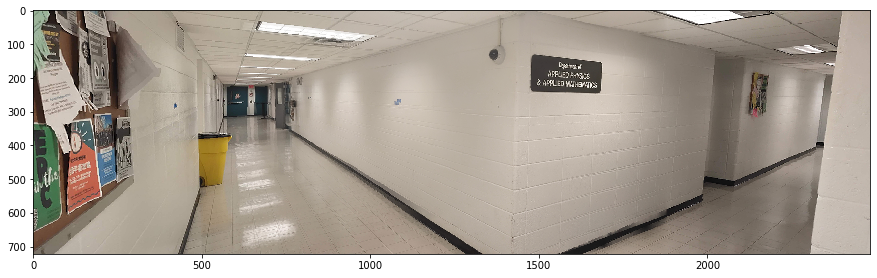

In [35]:
center_img = cv2.imread("myimage_center.jpg")
left_img = cv2.imread("myimage_left.jpg")
right_img = cv2.imread("myimage_right.jpg")
img_list = [center_img,left_img,right_img]  
final_img = stitch_img(img_list)
plt.imshow(cv2.cvtColor(final_img.astype("uint8"), cv2.COLOR_BGR2RGB));